# Projet numérique de science des données - GSTALTER Pierre-Louis et FREYTHER Alexandre

## Introduction au projet

Il s'agit dans ce projet d'utiliser des données cartographiques décrivant des carrées de 30m x 30m pour construire un modèle prédictif de l'espèce d'arbre présente sur un tel carré.

Le but final est d'appliquer ce modèle pour faire des prédictions pour des données pour lesquelles vous ne disposez pas d'une étiquette.

__Consignes :__ 
* Vous devez rendre, par binôme :
    * un notebook jupyter
    * un fichier de prédictions (voir plus bas pour le format)
* __Renseignez vos noms/prénoms__ dans le titre du notebook
* Vous avez jusqu'au __1er juillet midi heure de Paris__
* Déposez vos fichiers [sur Campus](https://campus.mines-paristech.fr/course/view.php?id=404) dans la section dédiée (un seul rendu par binôme est nécessaire)


__Déroulé :__
* Les séances du lundi 14/06 (15h30-17h) et jeudi 24/06 (15h30-17h) sont dédiées au projet numérique. Faites-en bon usage.
* Certaines sections font appel à des notions qui n'auront pas encore été vues le 14/06 ; c'est indiqué le cas échéant.

## Données

### Données publiques et privées

Le dossier `data/` contient deux jeux de données :
* `data/foret_public.tsv` contient les données étiquetées, à partir desquelles construire votre modèle
* `data/foret_prive.tsv` contient les données non-étiquetées, pour lesquelles faire vos prédictions.

Chaque ligne dans les données correspond à un carré de 30 m x 30m, décrit par les variables suivantes :
* `altitude` : altitude en mètres
* `exposition` : azimut en degrés 
* `pente` : pente en degrés
* `distance_horizontale_hydro` : distance horizontale au point d'eau le plus proche (en mètres)
* `distance_verticale_hydro` : distance verticale au point d'eau le plus proche (en mètres)
* `distance_horizontale_route` : distance horizontale à la route la plus proche (en mètres)
* `ombrage_0900` : index d'ombrages à 9h du matin, au solstice, sur une échelle de 0 à 255
* `ombrage_1200` : index d'ombrages à midi, au solstice, sur une échelle de 0 à 255
* `ombrage_1500` : index d'ombrages à 15h, au solstice, sur une échelle de 0 à 255
* `distance_horizontale_depart_feu` : distance horizontale au départ de feu de forêt le plus proche (en mètres)
* `espece` : étiquette : espèce d'arbre présente (0 = pin tordu ; 1 = peuplier)|

### Chargement des données étiquetées

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
df_public = pd.read_csv('data/foret_public.tsv', delimiter='\t')

In [4]:
df_public.head()

,altitude,exposition,pente,distance_horizontale_hydro,distance_verticale_hydro,distance_horizontale_route,ombrage_0900,ombrage_1200,ombrage_1500,distance_horizontale_depart_feu,espece
0,2804,139,9,268,65,3180,234,238,135,6121,0
1,2785,155,18,242,118,3090,238,238,122,6211,0
2,2579,132,6,300,-15,67,230,237,140,6031,0
3,2886,151,11,371,26,5253,234,240,136,4051,0
4,2742,134,22,150,69,3215,248,224,92,6091,0


In [5]:
colonnes = df_public.columns.to_list()

### Extraction de la matrice de design et des étiquettes 

In [6]:
X_public = np.array(df_public.drop(columns=["espece"]))
y_public = np.array(df_public["espece"])

### Visualisation des variables

#### Question 1
Visualisez chacune des variables de `X_public` sous la forme de deux histogrammes superposés, l'un correspondant aux observations de la classe positive, l'autre correspondant aux observations de la classe négative.

__Conseils :__
* utilisez `pos_indices = np.where(y_public==1)[0]` pour déterminer les indices des lignes de `y_public` (et donc dans `X_public`) dont l'étiquette vaut 0.
* utilisez l'argument `alpha` de `plt.hist` pour rendre vos histogrammes transparents.

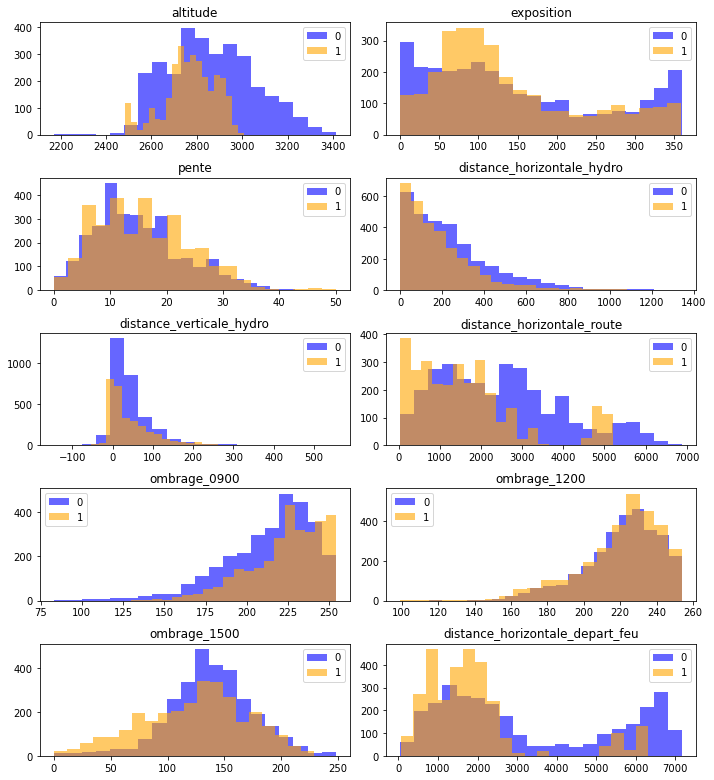

In [7]:
fig = plt.figure(figsize=(10, 15))
for i in range(10):
    ax = fig.add_subplot(7, 2, i + 1)
    ax.hist(X_public[:, i][np.where(y_public==0)[0]], bins=20, alpha=.6, color='blue')
    ax.set_title(f"{colonnes[i]}")
    ax.hist(X_public[:, i][np.where(y_public==1)[0]], bins=20, alpha=.6, color='orange')
    ax.legend('01')
fig.tight_layout(pad=1.0)

#### Question 2
Pensez-vous qu'il va être aisé de distinguer les deux classes ?

Cela semble difficile : il y a, pour la plupart des caractéristiques (ombrage, distance hydro, pente par exemple), une forte corrélation entre les deux. D'autres caractéristiques sont (un peu) plus discriminantes : distance feu ...

### Pré-traitement des variables

#### Question 3
Transformez vos variables d'une manière qui vous parait judicieuse, en vous appuyant notamment sur la PC 3. Vous pouvez essayer différents pré-traitements, mais ce n'est pas nécessaire. Justifiez vos choix. Utilisez un array numpy `X_public_preprocessed` pour enregistrer le résultat.

#### Réponse

Une première idée est de centrer et réduire les variables, car elles évoluent sur des plages différentes.

In [8]:
def scaler(tab):
    return (tab - np.mean(tab))/np.std(tab)

In [9]:
X_public_preprocessed = np.array([scaler(X_public[:, i]) for i in range(10)]).T

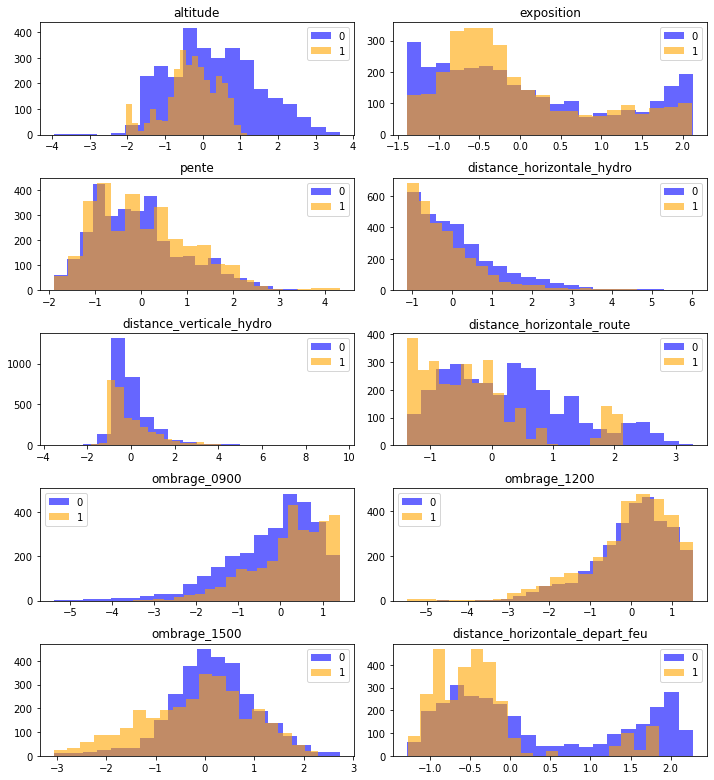

In [10]:
fig = plt.figure(figsize=(10, 15))
for i in range(10):
    ax = fig.add_subplot(7, 2, 1 + i)
    ax.hist(X_public_preprocessed[:, i][np.where(y_public==0)[0]], bins=20, alpha=.6, color='blue')
    ax.set_title(f"{colonnes[i]}")
    ax.hist(X_public_preprocessed[:, i][np.where(y_public==1)[0]], bins=20, alpha=.6, color='orange')
    ax.legend('01')
fig.tight_layout(pad=1.0)

## Premier modèle : 5-NN

### Algorithme des k plus proches voisins

Nous n'avons pas encore vu d'algorithme permettant d'entraîner un modèle de classification. Nous allons donc commencer avec un modèle simple : celui des __k plus proches voisins__ (ou __kNN__, pour _k nearest neighbors_).

Dans ce modèle, la valeur de la fonction de décision en x est la proportion d'individus d'étiquette positive parmi les k plus proches voisins de x au sein des points du jeu d'entraînement ; k est fixé.

Nous allons commencer par utiliser un algorithme des k plus proches voisins avec k fixé à k=5.

#### Question 4

Entraînez un modèle des sur les données `(X_public_preprocessed, y_public)` grâce à la classe `KNeighborsClassifier` du module `neighbors` de `sklearn`, utilisez l'algorithme des 5 plus proches voisins pour entrainer un modèle sur votre jeu d'entraînement.

Documentation https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [11]:
from sklearn import neighbors

In [12]:
_5NN_predictor = neighbors.KNeighborsClassifier(n_neighbors=5)

In [13]:
_5NN_predictor.fit(X_public_preprocessed, y_public);

In [14]:
y_pred = _5NN_predictor.predict(X_public_preprocessed)

### Performance

Il existe de nombreuses métriques pour évaluer les performances d'un algorithme de classification. Nous allons ici utiliser le F-score, dont vous trouverez une description dans la documentation du module `metrics` de `sklearn` : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score et https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics.

#### Question 5
Quel serait sur nos données le F-score d'un modèle naïf prédisant systématiquement la classe positive ?

In [15]:
from sklearn.metrics import f1_score

In [16]:
y_naif = np.ones_like(y_pred)

In [17]:
print(f"On trouve {round(f1_score(y_public, y_naif), 3)}, sachant que le score est compris entre 0 (pas bien) et 1 (très bien)")

On trouve 0.667, sachant que le score est compris entre 0 (pas bien) et 1 (très bien)


#### Question 6

Quelle est le F-score du modèle de 5 plus proches voisins que vous venez d'entraîner, sur les données `(X_public_preprocessed, y_public)` ?

In [18]:
print(f"Le f1_score vaut {round(f1_score(y_public, y_pred), 3)}. On prédit donc mieux qu'en étant simplement naïf. C'est une bonne nouvelle !")

Le f1_score vaut 0.929. On prédit donc mieux qu'en étant simplement naïf. C'est une bonne nouvelle !


#### Question 7
* Que pensez-vous de cette performance ? 
* Est-ce une bonne idée d'évaluer le modèle sur le jeu d'entraînement ? (Réfléchissez en particulier au cas où k=1.)

In [19]:
# a faire

## Création d'un jeu de test

À partir de maintenant, nous allons séparer les données en un jeu d'entraînement, que nous utiliserons pour entraîner différents modèles, et un jeu de test, que nous utiliserons pour les comparer. (Cf CM 8).

In [20]:
from sklearn import model_selection

In [21]:
# Use 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_public, y_public, test_size=0.20,
                                                                    stratify=y_public,
                                                                    random_state=42) 
X_train.shape, X_test.shape

((4800, 10), (1200, 10))

### Performance sur le jeu de test d'un 5-NN entraîné sur le jeu d'entrainement

#### Question 8.a 

Entrainez de nouveau un modèle avec l'algorithme des 5 plus proches voisins, mais cette fois, utilisez uniquement le jeu d'entraînement. __Attention__ à bien « entraîner » votre pre-processing sur le jeu d'entraînement seulement ; considérez le jeu de test comme des données que vous ne voyez pas au moment de l'entraînement.

In [22]:
_25NN_predictor = neighbors.KNeighborsClassifier(n_neighbors=5);
_25NN_predictor.fit(X_train, y_train);

In [23]:
y_pred_2 = _25NN_predictor.predict(X_test)

#### Question 8.b
Évaluez le F-score sur le jeu de test du modèle entraîné à la question précédente.

In [24]:
print(f"Le f1_score vaut {round(f1_score(y_test, y_pred_2), 3)}.")

Le f1_score vaut 0.924.


#### Question 9
Commentez le F-score obtenu ci-dessus.

C'est très bien, mais ça reste légèrement inférieur à celui sans test.

## [À partir du CM 8 / de la PC 4] Sélection du nombre de plus proches voisins

#### Question 10.a 
Utilisez maintenant une validation croisée pour sélectionner la valeur optimale du nombre de voisins avec `GridSearchCV` (voir notamment PC4). 

Vous pouvez utiliser la grille de valeurs de k suivante, ou la modifier :

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
from sklearn import metrics

In [27]:
neighbor_grid = neighbors.KNeighborsClassifier()
k_values = np.arange(1, 11)
tuned_parameters = [{'n_neighbors': k_values}]
nb_folds = 5
grid = GridSearchCV(neighbor_grid, tuned_parameters, cv=nb_folds, refit=True, scoring=metrics.make_scorer(metrics.f1_score))
grid.fit(X_public_preprocessed, y_public)

scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

std_error = scores_std / np.sqrt(nb_folds)

#### Question 10.b
Quel est le F-score correspondant au nombre de voisin optimal ?

In [28]:
_opti_neighbors = np.argmax(scores) + 1

In [29]:
def pluriel(n):
    if n > 1:
        return 's'
    return ''

In [30]:
print(f'le F-score optimal est obtenu pour {_opti_neighbors} voisin{pluriel(_opti_neighbors)}, et vaut {round(scores[_opti_neighbors - 1],3)}')

le F-score optimal est obtenu pour 1 voisin, et vaut 0.834


#### Question 10.c

Quel est le F-score, sur le jeu de test, d'un modèle obtenu en entraînant un algorithme des k plus proches voisins, avec le k que vous venez de déterminer, sur le jeu d'entraînement ? Commentez.

In [31]:
opti_neigh_classi = neighbors.KNeighborsClassifier(n_neighbors=1)
opti_neigh_classi.fit(X_train, y_train)
y_pred_neigh = opti_neigh_classi.predict(X_test)
opti_score = f1_score(y_pred_neigh,y_test)

In [32]:
print(f'le F-score avec le nombre optimal de voisin{pluriel(_opti_neighbors)} ({_opti_neighbors}) est {round(opti_score, 3)}')

le F-score avec le nombre optimal de voisin (1) est 0.949


C'est un très bon score. Il est supérieur aux précédents donc on a bien fait de s'embêter à optimiser le nombre de voisins, surtout que ça nous coûte moins cher s'il n'y en a qu'un seul.

## [À partir de la PC 5] Régression logistique

### Régression logistique non-régularisée

#### Question 11.a

Entraînez une régression logistique non-régularisée sur le jeu d'entraînement.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `LogisticRegression` du module `linear_model` de `scikit-learn` ; il s'agit ainsi d'une variante de la PC5. Comme toujours, référez-vous à la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
* Pour ne pas avoir de régularisation, utilisez `penalty='none'`

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
logic = LogisticRegression(random_state=42, max_iter=10000, penalty='none')
logic.fit(X_train, y_train)
y_pred_logic = logic.predict(X_test)

#### Question 11.b
Évaluez le F-score de cette régression logistique non-régularisée sur le jeu de test.

In [35]:
print(f'Le F-score vaut {round(f1_score(y_pred_logic, y_test), 3)}')

Le F-score vaut 0.766


#### Question 12
Vous attendez-vous à ce qu'utiliser une régularisation l2 améliore les performances du modèle ? Pourquoi ?

__Réponse__ __:__ Je sais pas :(

#### Question 13.a
Déterminez par validation croisée une valeur optimale du coefficient de régularisation d'une régression logistique avec régularisation ridge.

In [36]:
from sklearn.linear_model import Ridge

In [37]:
ridge_grid = Ridge(random_state=42, max_iter=1e4)

alphas = np.logspace(-5, 5, 100)
tuned_parameters = [{'alpha': alphas}]
nb_folds = 5
grid = GridSearchCV(ridge_grid,
                    tuned_parameters,
                    cv=nb_folds,
                    refit=True)

In [38]:
grid.fit(X_train, y_train);

In [39]:
# get NMSE
scores_nmse = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

# compute standard errors
std_error = scores_std / np.sqrt(nb_folds)

# get optimal alpha
i_max = np.argmax(scores_nmse)

# Transform NMSE into MSE
scores_mse = -scores_nmse

best_alpha = alphas[i_max]
best_score = scores_mse[i_max]
best_score_std = scores_std[i_max]

In [40]:
print(f'On trouve un alpha optimal à {round(best_alpha, 3)} ; cela correspond à un score de {round(best_score, 3)}. Nous allons maintenant affiner les valeurs de alpha.')

On trouve un alpha optimal à 1519.911 ; cela correspond à un score de -0.318. Nous allons maintenant affiner les valeurs de alpha.


In [41]:
# essayons d'affiner

alphas_2 = np.linspace(1450, 1650, 100)
tuned_parameters_2 = [{'alpha': alphas_2}]
grid_2 = GridSearchCV(ridge_grid,
                    tuned_parameters_2,
                    cv=nb_folds,
                    refit=True)
grid_2.fit(X_train, y_train)
# get NMSE
scores_nmse_2 = grid.cv_results_['mean_test_score']
scores_std_2 = grid.cv_results_['std_test_score']

# compute standard errors
std_error_2 = scores_std_2 / np.sqrt(nb_folds)

# get optimal alpha
i_max_2 = np.argmax(scores_nmse_2)

# Transform NMSE into MSE
scores_mse_2 = - scores_nmse_2

best_alpha_2 = alphas_2[i_max_2]
best_score_2 = scores_mse_2[i_max_2]
best_score_std_2 = scores_std_2[i_max_2]

In [42]:
print(f'On trouve un alpha optimal à {round(best_alpha_2, 3)} ; cela correspond à un score de {round(best_score_2, 3)}.')

On trouve un alpha optimal à 1613.636 ; cela correspond à un score de -0.318.


Ok à voir. En affinant l'échelle on retombe à peu près sur la même valeur donc pas d'inquiétude.

#### Question 13.b
Quel est le F-score, sur le jeu de test, d'une régression logistique avec régularisation ridge et ce coefficient de régularisation optimal, entraînée sur le jeu d'entraînement ?

In [43]:
opti_ridge = Ridge(alpha=1519.9, random_state=42)
opti_ridge.fit(X_train, y_train)
y_pred_ridge = opti_ridge.predict(X_test)

In [44]:
# F-score ne fonctionne pas pour l'instant pourtant les deux arrays ont meme shape et dtype :(

#### Question 13.c
Commentez ce résultat en regard de votre réponse à la question 12.

#### Question 14

Entraînez une forêt aléatoire sur le jeu d'entraînement et évaluez son F-score sur le jeu de test.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `RandomForestClassifier` du module `ensemble` de `scikit-learn`.
* Choisissez le nombre d'arbres par validation croisée.

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
forest = RandomForestClassifier(max_depth=50, random_state=42)
forest.fit(X_train, y_train)

y_forest_pred = forest.predict(X_test)

In [47]:
print(f'On obtient un F-score de {round(f1_score(y_forest_pred, y_test), 3)}')

On obtient un F-score de 0.936


Après plusieurs tests, on observe qu'en augmentant encore le nombre d'arbres, on n'arrive pas à faire mieux que 0.936, aussi on s'arrête à cinquante afin d'optimiser le temps de calcul.

## Modèle final

#### Question 15.a
Visualisez les performances des différents modèles (et pré-traitements) que vous avez évalués sur le jeu de test.

In [48]:
versions = [y_forest_pred, y_pred_2, y_pred_logic, y_pred_neigh] #y_naif, y_pred
versions_txt = ['forêt', 'voisins', 'logistique', 'voisins optimisé']

modèle : forêt


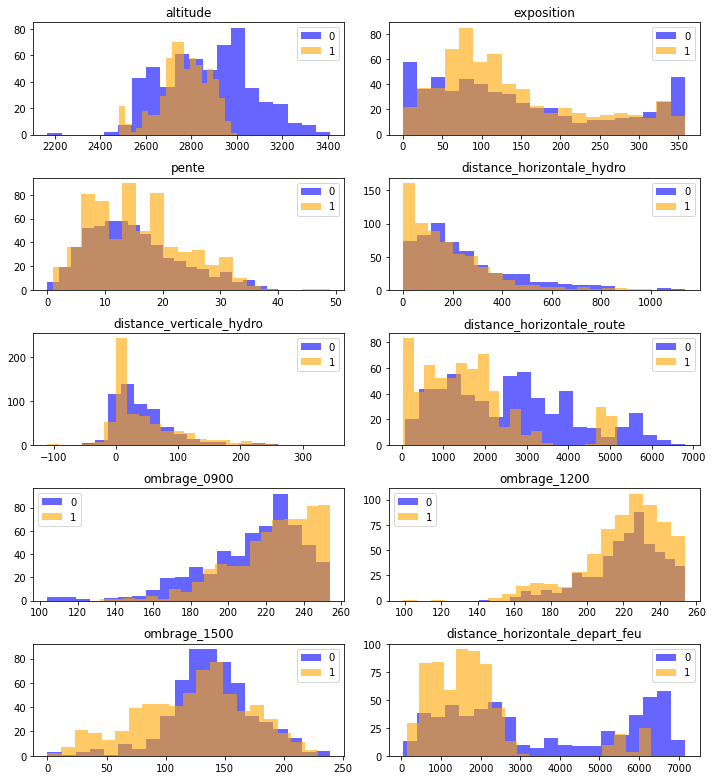


modèle : voisins


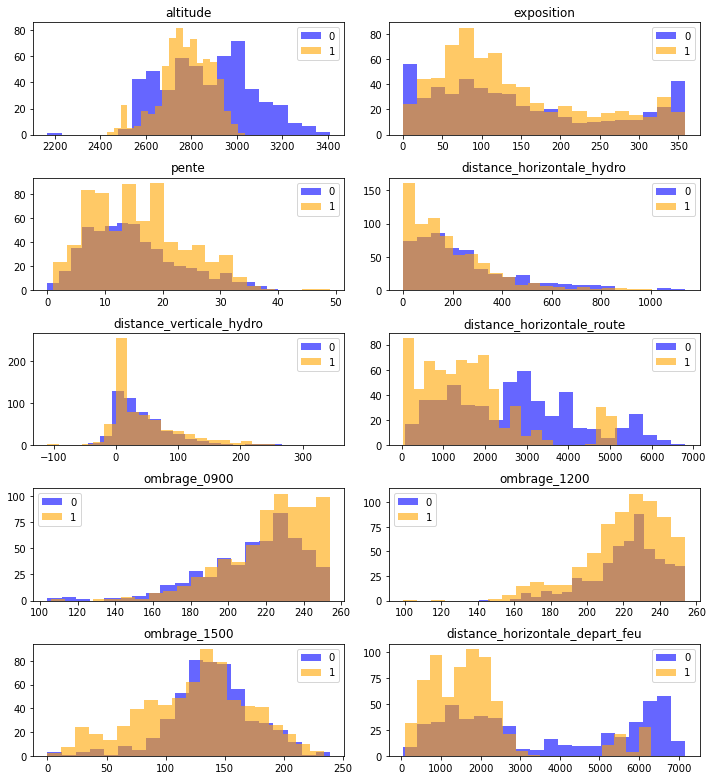


modèle : logistique


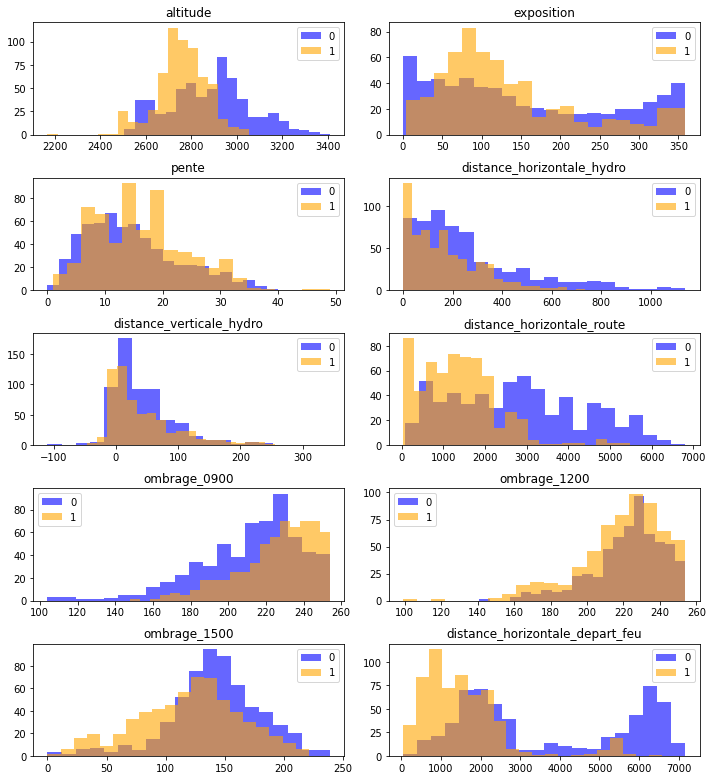


modèle : voisins optimisé


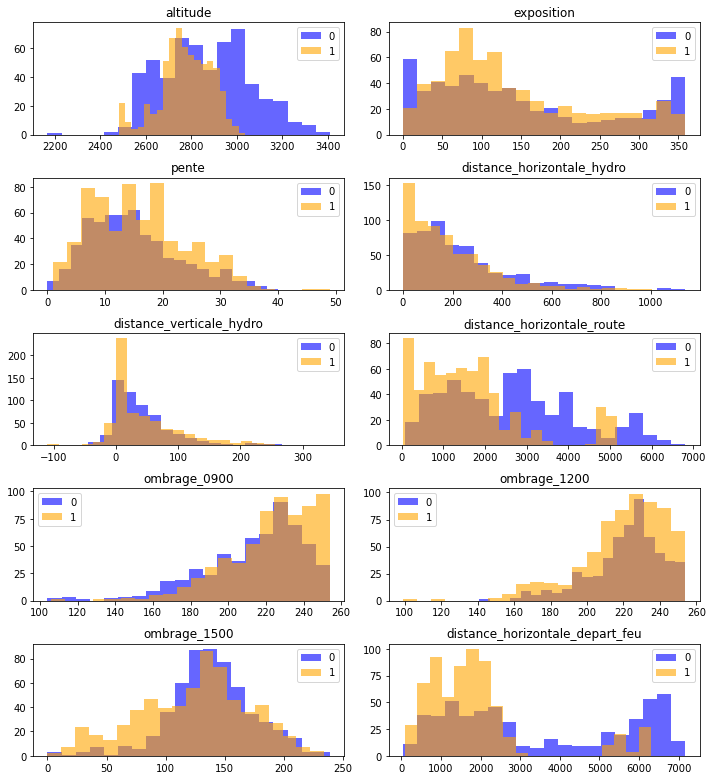

In [49]:
k = 0
for j in versions:
    print(f'modèle : {versions_txt[k]}')
    fig = plt.figure(figsize=(10, 15))
    for i in range(10):
        ax = fig.add_subplot(7, 2, i + 1)
        ax.hist(X_test[:, i][np.where(j == 0)[0]], bins=20, alpha=.6, color='blue')
        ax.set_title(f"{colonnes[i]}")
        ax.hist(X_test[:, i][np.where(j == 1)[0]], bins=20, alpha=.6, color='orange')
        ax.legend('01')
    fig.tight_layout(pad=1.0)
    plt.show()
    k += 1
    print()

#### Question 15.b
Utilisez cette figure pour __sélectionner votre modèle favori__. Quel pré-traitement choisissez-vous ? Quel algorithme choisissez-vous, avec quel hyper-paramètre ? 

Je préfère celui des voisins optimisé (avec un seul voisin donc).

#### Question 16.a
Chargez les données privées de `data/foret_prive.tsv` pour obtenir un array `X_private`. Le fichier suit la même syntaxe que `data/foret_public.tsv`, mais sans la colonne des étiquettes.

In [50]:
df_prive = pd.read_csv('data/foret_prive.tsv', delimiter='\t')

In [51]:
X_private = np.array(df_prive)

#### Question 16.b
Appliquez le pré-traitement que vous avez choisi à l'intégralité du jeu de données public `X_public` pour obtenir `X_public_preprocessed`.

In [52]:
X_public_preprocessed = np.array([scaler(X_public[:, i]) for i in range(10)]).T

#### Question 16.c
Appliquez à `X_private` le pré-traitement que vous avez choisi ; enregistrez le résultat dans `X_private_preprocessed`.

In [53]:
X_private_preprocessed = np.array([scaler(X_private[:, i]) for i in range(10)]).T

#### Question 16.d
Entraînez l'algorithme que vous avez sélectionné sur l'intégralité des données publiques `(X_public_processed, y_public)`. 

In [54]:
opti_neigh_classi = neighbors.KNeighborsClassifier(n_neighbors=1)
opti_neigh_classi.fit(X_public_preprocessed, y_public)
y_tot_pred = opti_neigh_classi.predict(X_public_preprocessed)
opti_score2 = f1_score(y_tot_pred, y_public)

In [55]:
print(f'Le F-score vaut {opti_score2}')

Le F-score vaut 1.0


#### Question 16.e
Prédisez les étiquettes de `X_private_preprocessed` ; enregistrez le résultat dans un array `y_pred_final`

In [56]:
y_pred_final = opti_neigh_classi.predict(X_private_preprocessed)

#### Question 16.f
Utilisez le code suivant pour créer le fichier de prédictions que vous rendrez. 

__Attention__ Si vous ouvrez ce fichier avec un programme externe type Microsoft Excel ou LibreOffice Calc pour le lire, il est possible que ce programme modifie le fichier sans que vous ne le réalisiez. Préférez utiliser une commande bash type `less` ou `cat` ou éditeur de texte simple ; ou alors assurez-vous de relancer la commande.

In [57]:
# Save array to file
np.savetxt("test_file.tsv", 
           y_pred_final,
           fmt=('%d'), 
           header='Prediction',
           delimiter='\t', comments="")

In [58]:
#! cat test_file.tsv

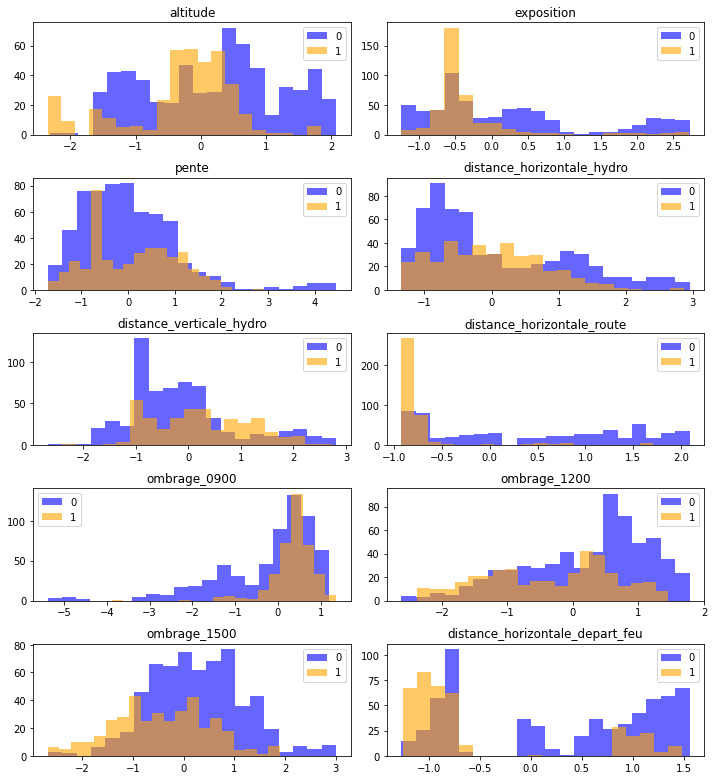

In [59]:
fig = plt.figure(figsize=(10, 15))
for i in range(10):
    ax = fig.add_subplot(7, 2, i + 1)
    ax.hist(X_private_preprocessed[:, i][np.where(y_pred_final == 0)[0]], bins=20, alpha=.6, color='blue')
    ax.set_title(f"{colonnes[i]}")
    ax.hist(X_private_preprocessed[:, i][np.where(y_pred_final == 1)[0]], bins=20, alpha=.6, color='orange')
    ax.legend('01')
fig.tight_layout(pad=1.0)
plt.show()

## Bonus

1. En alternative au F-score, utilisez des courbes ROC (et l'aire sous ces courbes) pour comparer vos modèles. Attention à utiliser les méthodes `predict_proba()` plutôt que `predict()` pour obtenir des scores non-seuillés plutôt que des prédictions binaires. Documentation pertinente : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html et  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html.

1. Explorez d'autres pré-traitements (comme par exemple le fait de réduire la dimension des données) et d'autres algorithmes d'apprentissage implémentés dans scikit-learn (par exemple SVM, perceptrons multi-couches) pour essayer d'améliorer vos prédictions et reprenez la question 15.